<img src="https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png" style="float:  left; margin: 10px;">

# Classification Review and Churn Case Study  
---
Week 4 | Lesson 4.1

### LEARNING OBJECTIVES
*After this lesson, you will be able to:*
- **Describe** examples in which optimizing precision over recall is desired and vice versa
- **Graph and Analyze** ROC and Precision-Recall Curves 
- **Demonstrate** an understanding of feature engineering by applying it to a data set
- **Demonstrate and apply** different methods to balance classification labels 
- **Analyze and explain** learning curves and what they are communicating about Logistic Regression performance
- **Synthesis** previously learned material to increase the predictive performance of Logistic Regression
- **Interpret** the odds ratios of Logistic Regression


In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from statsmodels.stats.weightstats import ttest_ind
from __future__ import division

%matplotlib inline

# modeling
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score 
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import scale, MinMaxScaler, normalize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTE
from collections import Counter

## 1 Exploratory Data Analysis

### 1.1 Clean Data

In [128]:
data_path = "~/DSI-SF-5/datasets/churn.csv"
df = pd.read_csv(data_path)

In [129]:
df.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [130]:
# inspect the head, there are features that need to be cleaned
# replace 'no'/'yes' values with 0 and 1
# change "Churn?" to "Churn"
# check data types of each column 

#### Head Observations 

1. There are a mixture of data types (strings and numerical) 
2. Some columns are likely not useful for modeling (state, account lenght, area code, and phone). 
3. We have features binary values that need to be transformed into one's and zeros. 
4. The churn column name needs to be reformated and it appears to have stings values. 

In [131]:
# replace any positve categorical with 1 
true = ["yes",
        "True",
        "True."]
# replace any negative categorical with 0
false = ["no",
         "False",
         "False."]

df.replace(to_replace=true, value=1, inplace=True)
df.replace(to_replace=false, value=0, inplace=True)

In [132]:
# sanity check your change by printing a head and checking that your change did what you expected
df.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,0,1,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,OH,107,415,371-7191,0,1,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,NJ,137,415,358-1921,0,0,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,OH,84,408,375-9999,1,0,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,OK,75,415,330-6626,1,0,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


In [133]:
# rename churn column
df.rename(columns={'Churn?':'Churn'}, 
          inplace=True)

In [134]:
# sanity check your change by printing a head and checking that your change did what you expected
df.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn
0,KS,128,415,382-4657,0,1,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,OH,107,415,371-7191,0,1,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,NJ,137,415,358-1921,0,0,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,OH,84,408,375-9999,1,0,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,OK,75,415,330-6626,1,0,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


In [135]:
Y = df.Churn.values

In [136]:
Counter(Y)

Counter({0: 2850, 1: 483})

In [137]:
df.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn
0,KS,128,415,382-4657,0,1,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,OH,107,415,371-7191,0,1,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,NJ,137,415,358-1921,0,0,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,OH,84,408,375-9999,1,0,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,OK,75,415,330-6626,1,0,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


### 1.2 Summery Statistics

The statistical summery table shows us that the feature distributions vary widely between each other. For instance, look at the means and std column. The means vary from 0.09 to 200 while the stds vary from 0.29 to 50. 

This indicates that the magitude of values will vary from feature to feature. This will negatively affect our model's ability to learn from our data. Recall that the gradient is sensitive to the magnitude of the values. 


>Since the range of values of raw data varies widely, in some machine learning algorithms, objective functions will not work properly without normalization. For example, the majority of classifiers calculate the distance between two points by the Euclidean distance. If one of the features has a broad range of values, the distance will be governed by this particular feature. Therefore, the range of all features should be normalized so that each feature contributes approximately proportionately to the final distance.

>Another reason why feature scaling is applied is that gradient descent converges much faster with feature scaling than without it

>--Wikipedia



In [138]:
# statistical summery table
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Account Length,3333.0,101.064806,39.822106,1.00,74.00,101.00,127.00,243.00
Area Code,3333.0,437.182418,42.371290,408.00,408.00,415.00,510.00,510.00
Int'l Plan,3333.0,0.096910,0.295879,0.00,0.00,0.00,0.00,1.00
VMail Plan,3333.0,0.276628,0.447398,0.00,0.00,0.00,1.00,1.00
VMail Message,3333.0,8.099010,13.688365,0.00,0.00,0.00,20.00,51.00
Day Mins,3333.0,179.775098,54.467389,0.00,143.70,179.40,216.40,350.80
Day Calls,3333.0,100.435644,20.069084,0.00,87.00,101.00,114.00,165.00
Day Charge,3333.0,30.562307,9.259435,0.00,24.43,30.50,36.79,59.64
Eve Mins,3333.0,200.980348,50.713844,0.00,166.60,201.40,235.30,363.70
Eve Calls,3333.0,100.114311,19.922625,0.00,87.00,100.00,114.00,170.00


To resolve this issue, we'll have to standardize our data. But first, let's look at visualization of our data before rescaling.

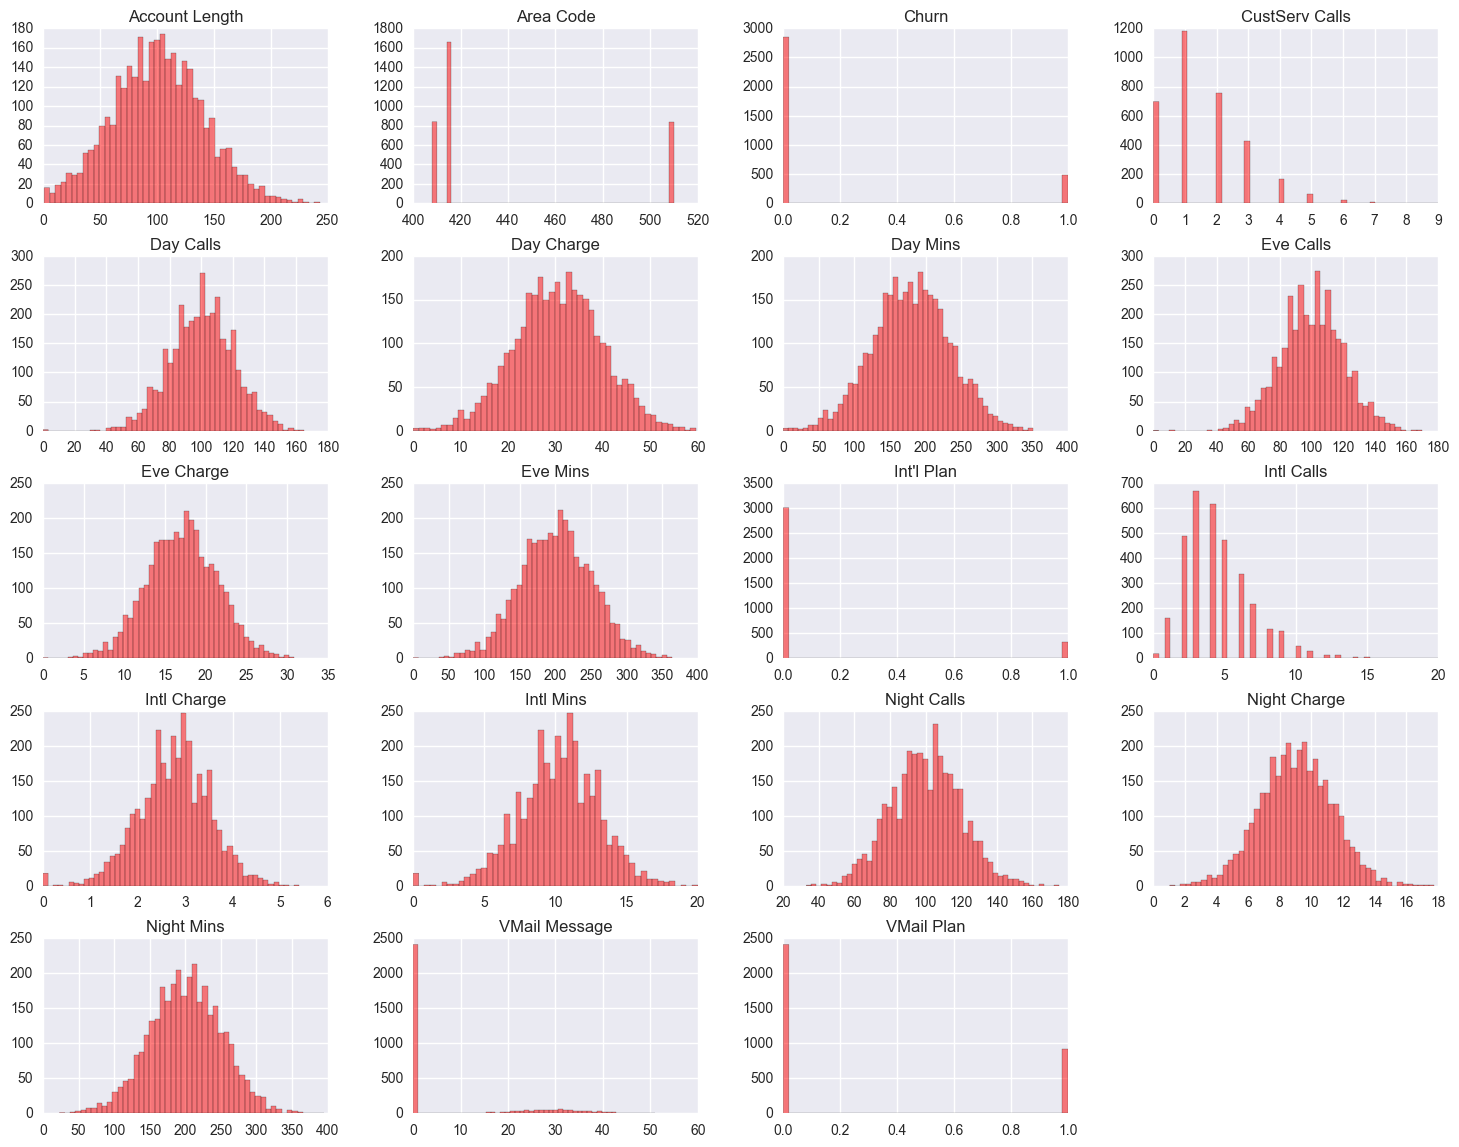

In [139]:
# Distribution of features - before rescaling
df.hist(color='r', alpha=0.5, bins=50, figsize=(18, 14));

#### Plot Observations 

The distribution plots show that most columns, such as Night Chage Eve Chage, are normal and are not skewed to the left or right indicating no statistical bias. That is great news. This means these distributions are accurate sample populations of the true underlying populations. 

Other features, such as Inti Calls and CustServ Calls, seems to be Possion distributions. Though Possion distributions represent the average rate of events with respect to time. We have no time dimension in our data set. Because of this, it is going to be difficult to interpret these features as a Possion distribution. 

Other features like VMail Plan and Churn are categorical and have a Bernoulli distribution. Take a close look at the churn distribution. It is telling us that we highly unbalanced classes. This is going to be very problematic for any predictive model. Highly unbalanced labels will bias our model's performance, resulting in poor performance in predicting the minority class. We'll have to address this issue after we scale our data. 

In [140]:
# print a head for reference
df.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn
0,KS,128,415,382-4657,0,1,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,OH,107,415,371-7191,0,1,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,NJ,137,415,358-1921,0,0,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,OH,84,408,375-9999,1,0,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,OK,75,415,330-6626,1,0,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


In [141]:
 df.columns[6:-1]

Index([u'VMail Message', u'Day Mins', u'Day Calls', u'Day Charge', u'Eve Mins',
       u'Eve Calls', u'Eve Charge', u'Night Mins', u'Night Calls',
       u'Night Charge', u'Intl Mins', u'Intl Calls', u'Intl Charge',
       u'CustServ Calls'],
      dtype='object')

In [142]:
# before scaling, exclude the categorical features
numerical_cols =  df.columns[6:-1]

In [143]:
# columns won't rescale unless dtype = "float"
df2 = df[numerical_cols].astype(float)

In [144]:
# scale along the features
df2 = df2.apply(lambda col: MinMaxScaler(feature_range=(-1,1)).fit_transform(col));

/Users/Alexander/anaconda3/envs/dsi/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/Alexander/anaconda3/envs/dsi/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/Alexander/anaconda3/envs/dsi/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your d

In [145]:
# Move columns with boolean values back into dataframe
# Move columns with boolean values back into dataframe
df2[df.columns[5]] = df[df.columns[5]].values
df2[df.columns[6]] = df[df.columns[6]].values
df2[df.columns[-1]] = df[df.columns[-1]].values

In [146]:
# view rescaled data
df2.head()

,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,VMail Plan,Churn
0,25,0.511403,0.333333,0.511402,0.085510,0.164706,0.085733,0.191501,-0.183099,0.191871,0.00,-0.7,0.000000,-0.777778,1,0
1,26,-0.078677,0.490909,-0.078806,0.075062,0.211765,0.075380,0.243679,-0.014085,0.244471,0.37,-0.7,0.370370,-0.777778,1,0
2,0,0.387685,0.381818,0.387659,-0.333517,0.294118,-0.333549,-0.250134,0.000000,-0.249253,0.22,-0.5,0.218519,-1.000000,0,0
3,0,0.706956,-0.139394,0.706908,-0.659610,0.035294,-0.659657,-0.065627,-0.211268,-0.065152,-0.34,-0.3,-0.340741,-0.555556,0,0
4,0,-0.049601,0.369697,-0.049631,-0.184493,0.435294,-0.184083,-0.119419,0.239437,-0.118948,0.01,-0.7,0.011111,-0.333333,0,0


In [96]:
# view statistical summery table
df2.describe().T

,count,mean,std,min,25%,50%,75%,max
VMail Message,3333.0,8.099010,13.688365,0.0,0.000000,0.000000,20.000000,51.0
Day Mins,3333.0,0.024944,0.310532,-1.0,-0.180730,0.022805,0.233751,1.0
Day Calls,3333.0,0.217402,0.243262,-1.0,0.054545,0.224242,0.381818,1.0
Day Charge,3333.0,0.024893,0.310511,-1.0,-0.180751,0.022803,0.233736,1.0
Eve Mins,3333.0,0.105199,0.278877,-1.0,-0.083860,0.107506,0.293924,1.0
Eve Calls,3333.0,0.177815,0.234384,-1.0,0.023529,0.176471,0.341176,1.0
Eve Charge,3333.0,0.105373,0.278917,-1.0,-0.083792,0.107732,0.294080,1.0
Night Mins,3333.0,-0.044260,0.272049,-1.0,-0.226466,-0.042496,0.140936,1.0
Night Calls,3333.0,-0.054821,0.275614,-1.0,-0.239437,-0.056338,0.126761,1.0
Night Charge,3333.0,-0.043715,0.272071,-1.0,-0.225344,-0.042439,0.141662,1.0


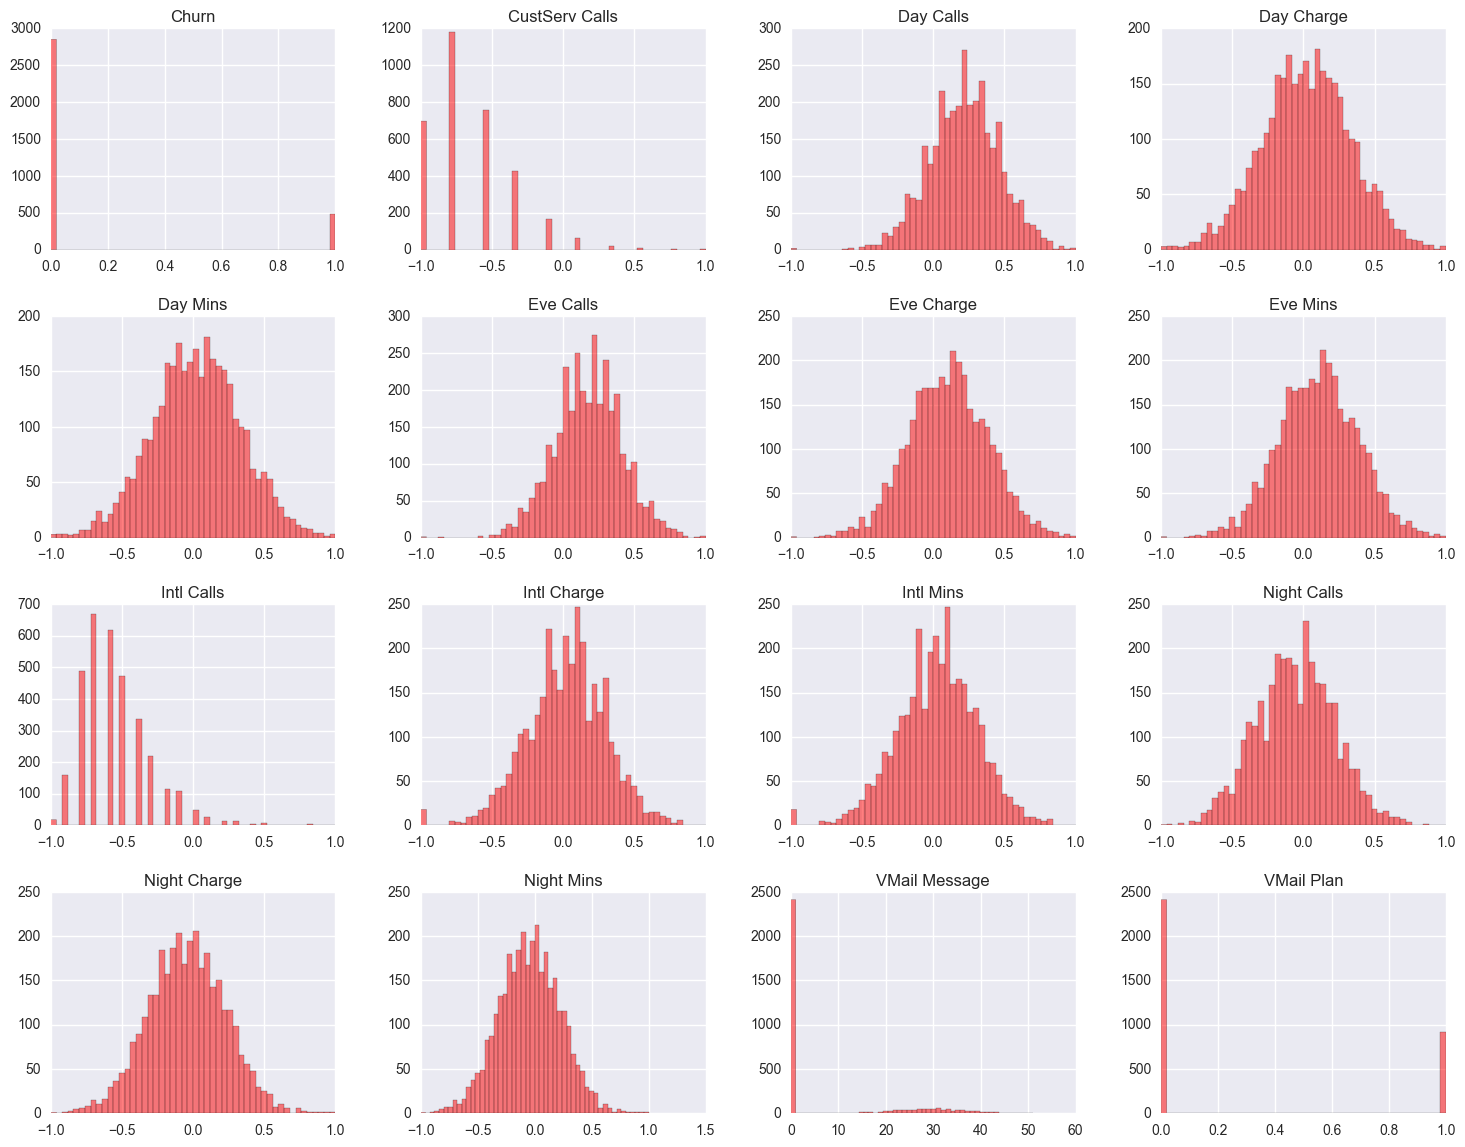

In [97]:
# Distribution of features - after rescaling
df2.hist(color='r', alpha=0.5, bins=50, figsize=(18, 14));

### 1.4 Balancing Classes

##### Why are imbalanced classes a problem?

We are interested in a fairly high rate of correct detection of the minority class (churn)
and we are wiling to allow for a small error rate in the majority class (don't churn). However an imbalanced data set prevents a classifier from being properly trained. Without enough churn data points, the classifer will not be able to learn enough of the predictive indicators of churn, therefore the model will do a poor job at predicting who will churn (Low recall and Low precison).
    
#### Baseline Accuracy 

Our goal is to build a model that can score a higher accuracy than our navie baseline accuracy. But accuracy is not enough, we also need a high precision scoure. 

#### Confusion Matrix Review
We can get a better picture of our model but looking at the confusion matrix. We get the following four metrics:

* **True Positives (TP)**: Correct positive predictions
* **False Positives (FP)**: Incorrect positive predictions (false alarm)
* **True Negatives (TN)**: Correct negative predictions
* **False Negatives (FN)**: Incorrect negative predictions (a miss)

|            | Predicted Yes  | Predicted No   |
| ---------- | -------------- | -------------- |
| Actual Yes | True positive  | False negative |
| Actual No  | False positive | True negative  |


* **Precision**: A measure of how good your positive predictions are
    ```python
    Precison = TP / (TP + FP)
             = TP / (predicted yes)
    ```
* **Recall**: A measure of how well you predict positive cases. Aka *sensitivity*.
    ```python
    Recall = TP / (TP + FN) 
           = TP / (actual yes)
    ```
    
#### For our data set

    FP = Predicted to churn, doesn't churn

    FN = Predicted to NOT churn, actually churns
    
    
#### Methods for balancing classifications


We will explore 3 approaches to balancing classes
- Undersampling the majority class
- Oversampling the minority class
- SMOTE (Synthetic Minority Oversampling Technique)

### Undersampling the Majority Class

##### Pro:
1. We can undersample the majority classs in order to obtain equal classifications. 

##### Cons:
1. The problem with this is that it will result in much smaller data set. 
2. Also we may be dropping important samples from the majoirty class. 

![](http://www.chioka.in/wp-content/uploads/2013/08/Undersampling.png)

In [98]:
def undersample(X, y, majority_weight=.5):
    '''
    randomly discards observations from majority class
    so that output X, y have specified percentage of majority observations
    '''
    class_ratio = y.sum()/float(len(y))
    majority_class_label = round(class_ratio)
    X_majority = X[y==majority_class_label]
    y_majority = y[y==majority_class_label]
    maj_count = len(X_majority)
    min_count = len(X) - maj_count
    scaling_factor = (min_count/float(maj_count))*(majority_weight/(1-majority_weight))
    sample_indices = np.random.choice(xrange(maj_count), 
                                      size=round(maj_count*scaling_factor),
                                      replace=False)
    X_majority = X_majority[sample_indices]
    y_majority = y_majority[sample_indices]
    X = np.vstack((X_majority, X[y!=majority_class_label]))
    y = np.hstack((y_majority, y[y!=majority_class_label]))
    return X, y

### Oversampling the Minority Class

##### Pro:
1. We can oversample the minorty classs in order to obtain equal classifications. 
2. This approach will not decrease our data set size, in fact it will increase it. 

##### Cons:
1. We will have multiple copies of minority samples which may lead to overfitting

![](http://www.chioka.in/wp-content/uploads/2013/08/Oversampling.png)

In [184]:
def oversample(X, y, minority_weight=.5):
    '''
    duplicates observations from minority class
    so that output X, y have specified percentage of majority observations
    '''
    class_ratio = y.sum()/float(len(y))
    majority_class_label = round(class_ratio)
    X_minority = X[y!=majority_class_label]
    y_minority = y[y!=majority_class_label]
    min_count = len(X_minority)
    maj_count = len(X) - min_count
    scaling_factor = int(round((maj_count/float(min_count))*(minority_weight/(1-minority_weight))))
    # tile repeats the obs in X_minority by the scaling_factor
    X_minority = np.tile(X_minority, (scaling_factor, 1))
    y_minority = np.tile(y_minority, scaling_factor)
    X = np.vstack((X_minority, X[y==majority_class_label]))
    y = np.hstack((y_minority, y[y==majority_class_label]))
    return X, y

###  SMOTE (Synthetic Minority Oversampling Technique)

##### Pro:
1. Generate slightly mutated copies of the minority class. 
2. Maintaining diversity in the minority class will help advoid overfitting. 

##### Cons:
1. May misrepresent the true population distribution of both classes. 

![](http://www.chioka.in/wp-content/uploads/2013/08/SMOTE-boundary.png)

#### General idea of how SMOTE works:

![](http://www.svds.com/wp-content/uploads/2016/08/ImbalancedClasses_fig11.png)

#### Open Source package 

You don't have to code SMOTE yourself. There is an open source package, with documentation. Best of all, it has over 10 different versions of SMOTE and SMOTE-like methods that balance unbalance data sets. There are also links to the research papers behind each version. Check it out! [SMOTE Versions](https://github.com/scikit-learn-contrib/imbalanced-learn) 



The docs also have plenty of examples, with visualization, that show [How SMOTE Works](http://contrib.scikit-learn.org/imbalanced-learn/auto_examples/over-sampling/plot_smote.html#sphx-glr-auto-examples-over-sampling-plot-smote-py)

In [100]:
def smote(X, y, minority_weight=.5):
    '''
    generates new observations in minority class
    so that output X, y have specified percentage of majority observations
    '''
    # compute number of new examples required
    # True = 1, False = 0 
    # If True is majority (>=.50) Then round(class_ratio) = 1.0 
    # Else if False is majoirty (< .50) Then round(class_ratio) = 0.0
    # For walk through, let majority class be False = 0
    class_ratio = y.sum()/float(len(y))
    # majority_class_label = 0.0
    majority_class_label = round(class_ratio)
    
    # X_minority holds all obs that correspond to the True label (minority class)
    X_minority = X[y!=majority_class_label]
    # y_minority holds all True values (minority class)
    y_minority = y[y!=majority_class_label]
    min_count = len(X_minority)
    maj_count = len(X) - min_count
    # scaling factor, for minority_weight = 0.5, reduces to Maj_count = SF * Min_count
    # the SF is the ratio between theh classes, muliplying by this will balance them
    scaling_factor = (maj_count/float(min_count))*(minority_weight/(1-minority_weight))
    # generate new_obs_targets so that the minority class will be balance with the majority class
    new_observations_target = round(scaling_factor*min_count) - min_count

    # train KNN
    knn_model = KNeighborsClassifier(n_neighbors=int(round(len(X_minority)**.5)))
    knn_model.fit(X_minority, y_minority)
    
    if new_observations_target < len(X_minority):
        sample_indices = np.random.choice(xrange(X_minority), 
                                          size=new_observations_target,
                                          replace=False)
        smote_samples = X_minority[sample_indices]
    else:
        smote_samples = X_minority
    neighbors = knn_model.kneighbors(smote_samples)[1]
    
    # generate new samples
    new_observations = np.empty((0,X.shape[1]))
    while len(new_observations) < new_observations_target:
        index = len(new_observations) % len(smote_samples)
        neighbor_index = np.random.choice(neighbors[index])
        neighbor = smote_samples[neighbor_index]
        x = X_minority[index]
        new_x = x + (neighbor - x)*np.random.random(size=X_minority.shape[1])
        new_observations = np.vstack((new_observations, new_x))
    minority_class_label = (majority_class_label + 1) % 2
    X = np.vstack((X, new_observations))
    y = np.hstack((y, np.array([minority_class_label]*len(new_observations))))
    
    return X, y

### 1.5 Implement Each Method


In [197]:
class cross_validation(object):
    '''This class provides cross validation of any data set why incrementally increasing number 
       of samples in the training and test set and performing KFold splits at every iteration. 
       During cross validation the metrics accuracy, recall, precision, and f1-score are recored. 
       The results of the cross validation are display on four learning curves. '''
    
    def __init__(self, model, X_data, Y_data, X_test=None, Y_test=None, 
                 n_splits=3, init_chunk_size = 100, chunk_spacings = 10, average = "binary"):

        self.X, self.Y =  shuffle(X_data, Y_data, random_state=1234)
        
        
        self.model = model
        self.n_splits = n_splits
        self.chunk_size = init_chunk_size
        self.chunk_spacings = chunk_spacings        
        
        self.X_train = []
        self.X_test = []
        self.Y_train = []
        self.Y_test = []
        self.X_holdout = []
        self.Y_holdout = []
        
        self.f1_train = []
        self.f1_test = []
        self.acc_train = []
        self.acc_test = []
        self.pre_train = []
        self.pre_test = []
        self.rec_train = []
        self.rec_test = []
        
        self.f1_mean_train = []
        self.f1_mean_test = []
        self.acc_mean_train = []
        self.acc_mean_test = []
        self.pre_mean_train = []
        self.pre_mean_test = []
        self.rec_mean_train = []
        self.rec_mean_test = []
        
        self.training_size = []
        self.averageType = average
    
    def make_chunks(self):
        '''Partitions data into chunks for incremental cross validation'''
        
        # get total number of points
        self.N_total = self.X.shape[0] 
        # partition data into chunks for learning
        self.chunks = list(np.arange(self.chunk_size, self.N_total, self.chunk_spacings ))
        self.remainder = self.X.shape[0] - self.chunks[-1]
        self.chunks.append( self.chunks[-1] + self.remainder )



    def train_for_learning_curve(self):
        '''KFold cross validates model and records metric scores for learning curves. 
           Metrics scored are f1-score, precision, recall, and accuracy'''

        # partiton data into chunks 
        self.make_chunks()
        # for each iteration, allow the model to use 10 more samples in the training set 
        self.skf = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=1234)
        # iterate through the first n samples
        for n_points in self.chunks: 
            
        
            # split the first n samples in k folds 
            for train_index, test_index in self.skf.split(self.X[:n_points], self.Y[:n_points]):
                
                self.train_index, self.test_index = train_index, test_index
                
                self.X_train = self.X[self.train_index]
                self.X_test = self.X[self.test_index]
                self.Y_train = self.Y[self.train_index]
                self.Y_test = self.Y[self.test_index]
                
                self.model.fit(self.X_train, self.Y_train)
                self.y_pred_train = self.model.predict(self.X_train)
                self.y_pred_test = self.model.predict(self.X_test)
                self.log_metric_scores_()   
                
            self.log_metric_score_means_()
            self.training_size.append(n_points)
        
    def validate_for_holdout_set(self, X_holdout, Y_holdout):
        
        
        self.X_test = X_holdout
        self.Y_test = Y_holdout
        
        # partiton data into chunks 
        self.make_chunks()
        
        for n_points in self.chunks:
            
            self.X_train = self.X[:n_points]
            self.Y_train = self.Y[:n_points]

            self.model.fit(self.X_train, self.Y_train)
            self.y_pred_train = self.model.predict(self.X_train)
            self.y_pred_test = self.model.predict(self.X_test)
            self.log_metric_scores_()   

            self.log_metric_score_means_()
            self.training_size.append(n_points)
            
            
    
                            
    def log_metric_score_means_(self):
        '''Recrods the mean of the four metrics recording during training'''
        self.f1_mean_train.append(np.sum(self.f1_train)/len(self.f1_train))
        self.f1_mean_test.append(np.sum(self.f1_test)/len(self.f1_test))
        
        self.acc_mean_train.append(np.sum(self.acc_train)/len(self.acc_train))
        self.acc_mean_test.append(np.sum(self.acc_test)/len(self.acc_test))
        
        self.pre_mean_train.append(np.sum(self.pre_train)/len(self.pre_train))
        self.pre_mean_test.append(np.sum(self.pre_test)/len(self.pre_test))
        
        self.rec_mean_train.append(np.sum(self.rec_train)/len(self.rec_train))
        self.rec_mean_test.append(np.sum(self.rec_test)/len(self.rec_test))
        
        self.reinitialize_metric_lists_()
            
            
    def reinitialize_metric_lists_(self):
        '''Reinitializes metrics lists for training'''
        self.f1_train = []
        self.f1_test = []
        self.acc_train = []
        self.acc_test = []
        self.pre_train = []
        self.pre_test = []
        self.rec_train = []
        self.rec_test = []

            
    def log_metric_scores_(self):
        '''Records the metric scores during each training iteration'''
        self.f1_train.append(f1_score(self.Y_train, self.y_pred_train, average=self.averageType))
        self.acc_train.append(accuracy_score( self.Y_train, self.y_pred_train) )

        self.pre_train.append(precision_score(self.Y_train, self.y_pred_train, average=self.averageType))
        self.rec_train.append(recall_score( self.Y_train, self.y_pred_train, average=self.averageType) )

        self.f1_test.append(f1_score(self.Y_test, self.y_pred_test, average=self.averageType))
        self.acc_test.append(accuracy_score(self.Y_test, self.y_pred_test))

        self.pre_test.append(precision_score(self.Y_test, self.y_pred_test, average=self.averageType))
        self.rec_test.append(recall_score(self.Y_test, self.y_pred_test,average=self.averageType))
            

    def plot_learning_curve(self):
        '''Plots f1 and accuracy learning curves for a given model and data set'''
        
        fig = plt.figure(figsize = (17,12))
        # plot f1 score learning curve
        fig.add_subplot(221)   # left
        plt.title("F1-Score vs. Number of Training Samples")
        plt.plot(self.training_size, self.f1_mean_train, label="Train")
        plt.plot(self.training_size, self.f1_mean_test, label="Test");
        plt.xlabel("Number of Training Samples")
        plt.ylabel("F1-Score")
        plt.legend(loc=4);
        
        # plot accuracy learning curve
        fig.add_subplot(222)   # right 
        plt.title("Accuracy vs. Number of Training Samples")
        plt.plot(self.training_size, self.acc_mean_train, label="Train")
        plt.plot(self.training_size, self.acc_mean_test, label="Test");
        plt.xlabel("Number of Training Samples")
        plt.ylabel("Accuracy")
        plt.legend(loc=4);
        
        # plot precision learning curve
        fig.add_subplot(223)   # left
        plt.title("Precision Score vs. Number of Training Samples")
        plt.plot(self.training_size, self.pre_mean_train, label="Train")
        plt.plot(self.training_size, self.pre_mean_test, label="Test");
        plt.xlabel("Number of Training Samples")
        plt.ylabel("Precision")
        plt.ylim(min(self.pre_mean_test), max(self.pre_mean_train) + 0.05)
        plt.legend(loc=4);
        
        # plot accuracy learning curve
        fig.add_subplot(224)   # right 
        plt.title("Recall vs. Number of Training Samples")
        plt.plot(self.training_size, self.rec_mean_train, label="Train")
        plt.plot(self.training_size, self.rec_mean_test, label="Test");
        plt.xlabel("Number of Training Samples")
        plt.ylabel("Recall")
        plt.legend(loc=4);


In [126]:
X = df2[df2.columns[6:-1]].values
Y = df2.Churn.values

In [127]:
df2.head()

,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,VMail Plan,Churn,row-means,row-std
0,25,0.511403,0.333333,0.511402,0.085510,0.164706,0.085733,0.191501,-0.183099,0.191871,0.00,-0.7,0.000000,-0.777778,1,0,1.646657,5.862492
1,26,-0.078677,0.490909,-0.078806,0.075062,0.211765,0.075380,0.243679,-0.014085,0.244471,0.37,-0.7,0.370370,-0.777778,1,0,1.709848,6.096116
2,0,0.387685,0.381818,0.387659,-0.333517,0.294118,-0.333549,-0.250134,0.000000,-0.249253,0.22,-0.5,0.218519,-1.000000,0,0,-0.041688,0.358801
3,0,0.706956,-0.139394,0.706908,-0.659610,0.035294,-0.659657,-0.065627,-0.211268,-0.065152,-0.34,-0.3,-0.340741,-0.555556,0,0,-0.110683,0.371899
4,0,-0.049601,0.369697,-0.049631,-0.184493,0.435294,-0.184083,-0.119419,0.239437,-0.118948,0.01,-0.7,0.011111,-0.333333,0,0,-0.035312,0.249438


In [124]:
X, Y = shuffle(X, Y)
X_train, X_holdout, Y_train, Y_holdout = train_test_split(X,Y, test_size = 0.20)

### Check for Understanding: Review Bias/Variance Tradeoff

### Undersampling

Regularization: Rigde 

/Users/Alexander/anaconda3/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


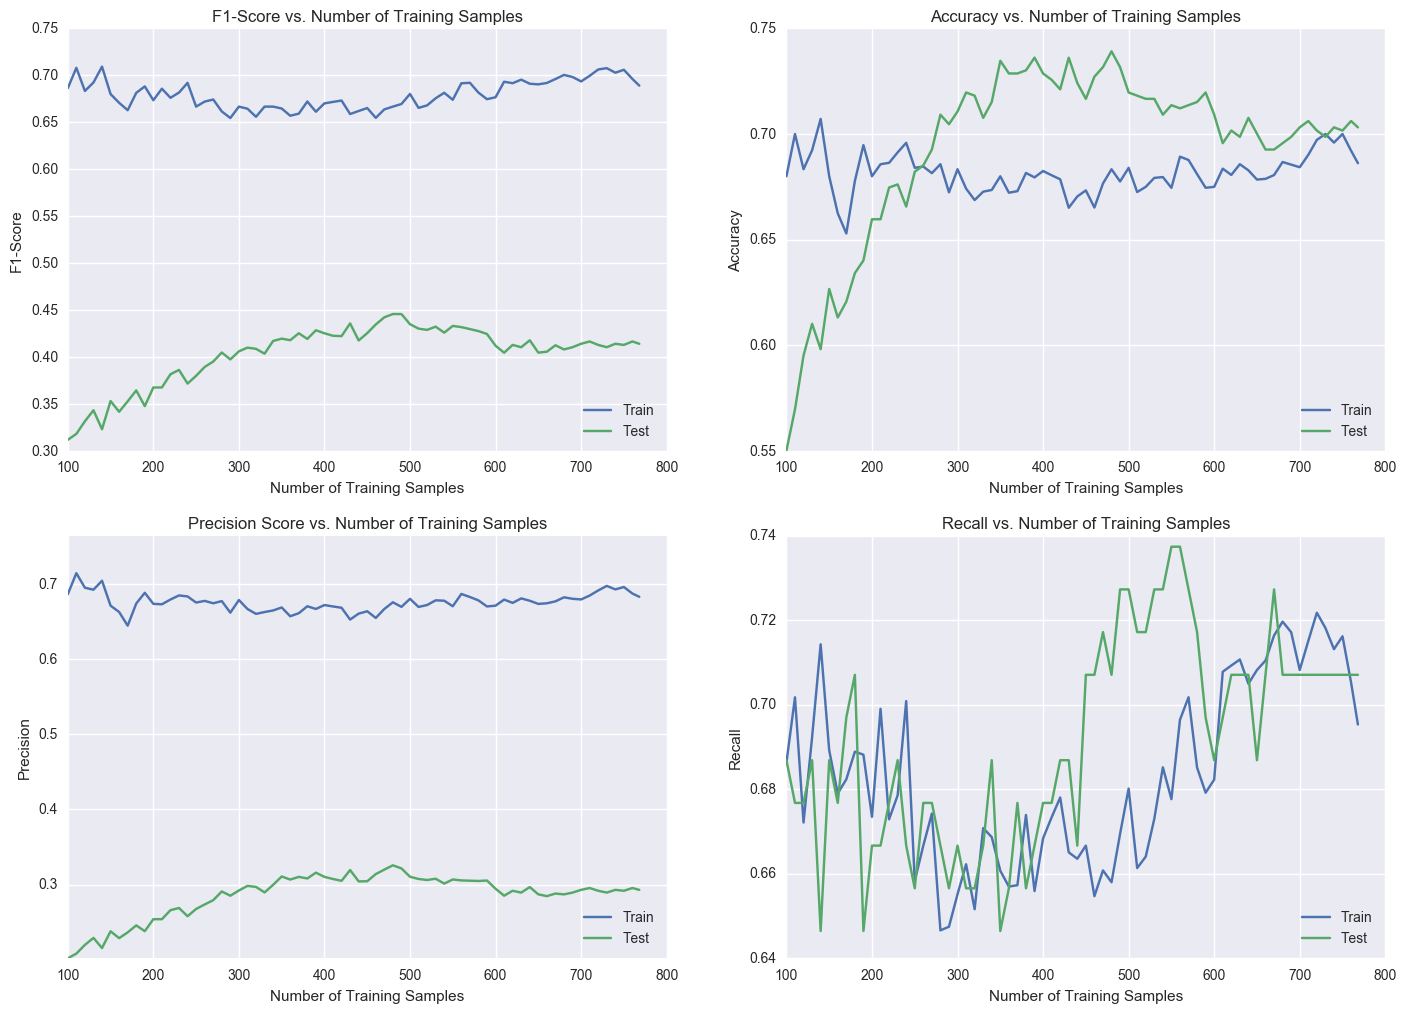

In [107]:
X_under, Y_under = undersample(X_train, Y_train, majority_weight=.5)
lr = LogisticRegression(penalty='l2')
cv = cross_validation(lr, X_under, Y_under , n_splits=5,init_chunk_size = 100, chunk_spacings = 10, average = "binary")
cv.validate_for_holdout_set(X_holdout, Y_holdout)
cv.plot_learning_curve()

In [116]:
# change cell to markdown and write down your interpretation about what the learning curve 
# is telling us about Logistic REgression preformance in terms of the bias/variance tradeoff

### Oversampling

Regularization: Ridge 

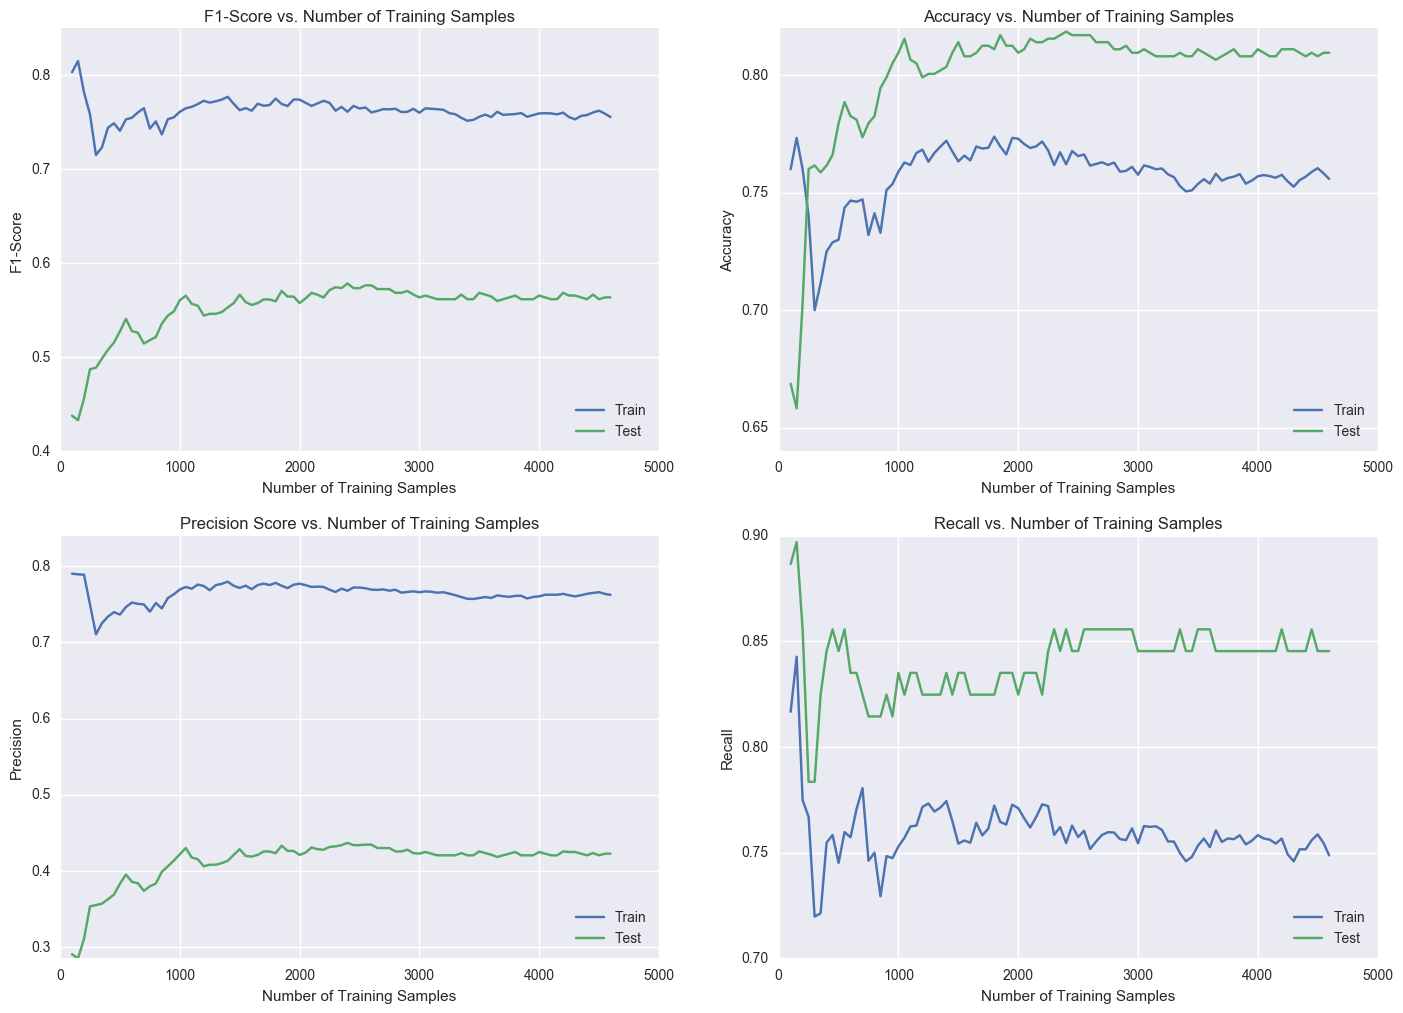

In [120]:
X_over, Y_over = oversample(X_train, Y_train, minority_weight=.5)
lr = LogisticRegression(penalty='l2')
cv = cross_validation(lr, X_over, Y_over , n_splits=5,init_chunk_size = 100, chunk_spacings = 50, average = "binary")
cv.validate_for_holdout_set(X_holdout, Y_holdout)
cv.plot_learning_curve()

In [ ]:
# change cell to markdown and write down your interpretation about what the learning curve 
# is telling us about Logistic REgression preformance in terms of the bias/variance tradeoff

### SMOTE

Regularization: Ridge

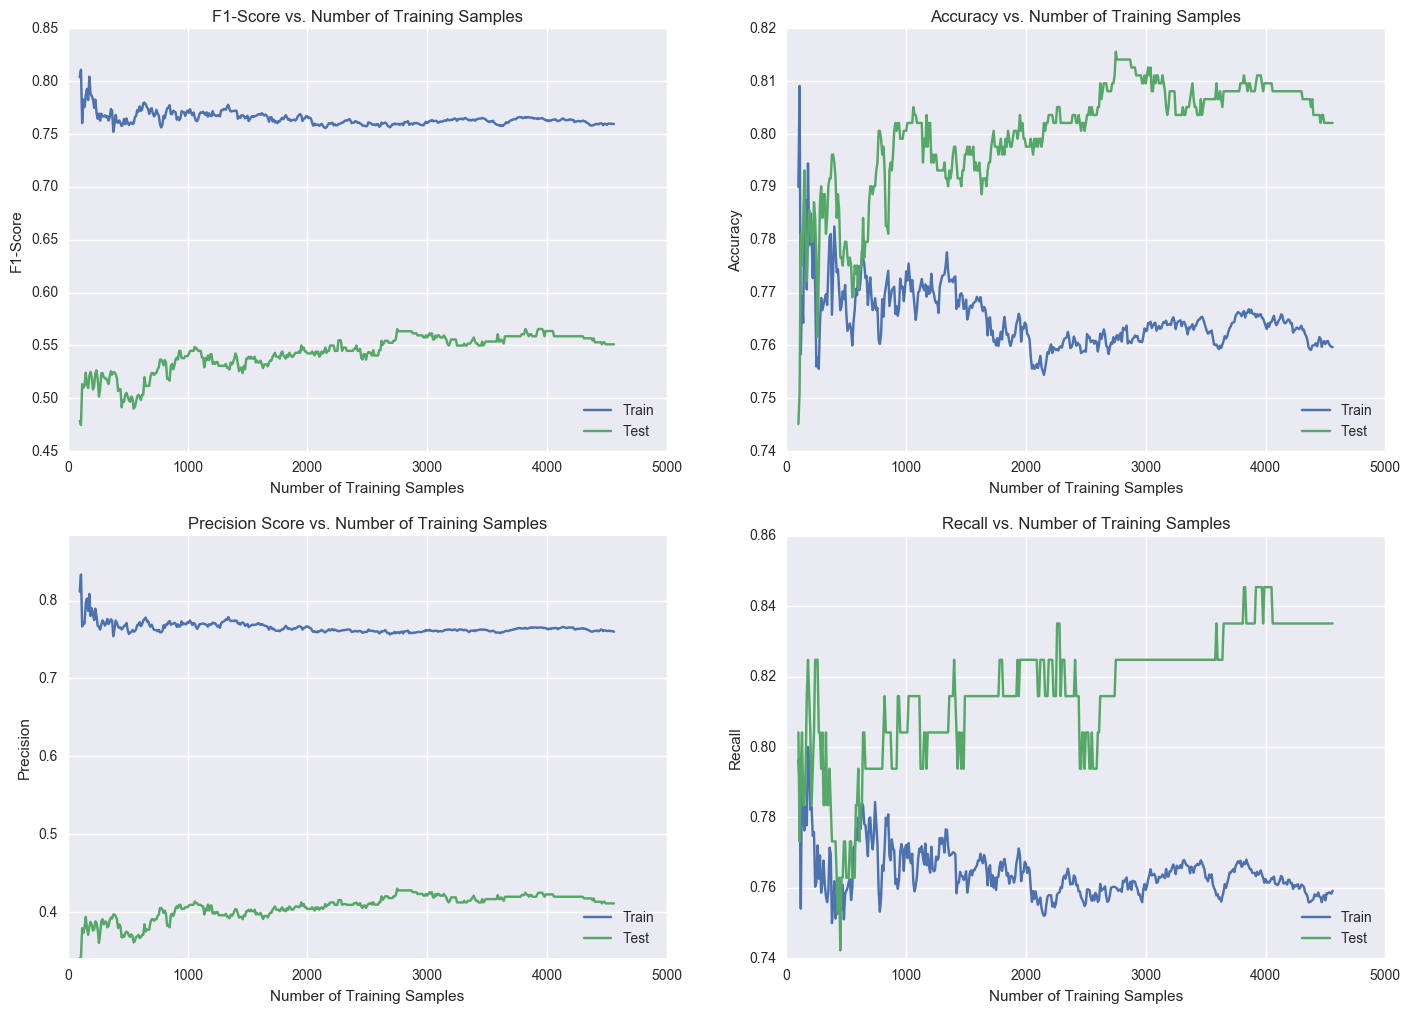

In [119]:
sm = SMOTE(kind='regular')
X_smote, Y_smote = sm.fit_sample(X_train, Y_train)

# let's see how well LR can fit and predict on the smote data
lr = LogisticRegression()
cv = cross_validation(lr, X_smote, Y_smote , n_splits=5, init_chunk_size = 100, chunk_spacings = 10, average = "binary")
cv.validate_for_holdout_set(X_holdout, Y_holdout)
cv.plot_learning_curve()

In [797]:
# change cell to markdown and write down your interpretation about what the learning curve 
# is telling us about Logistic REgression preformance in terms of the bias/variance tradeoff

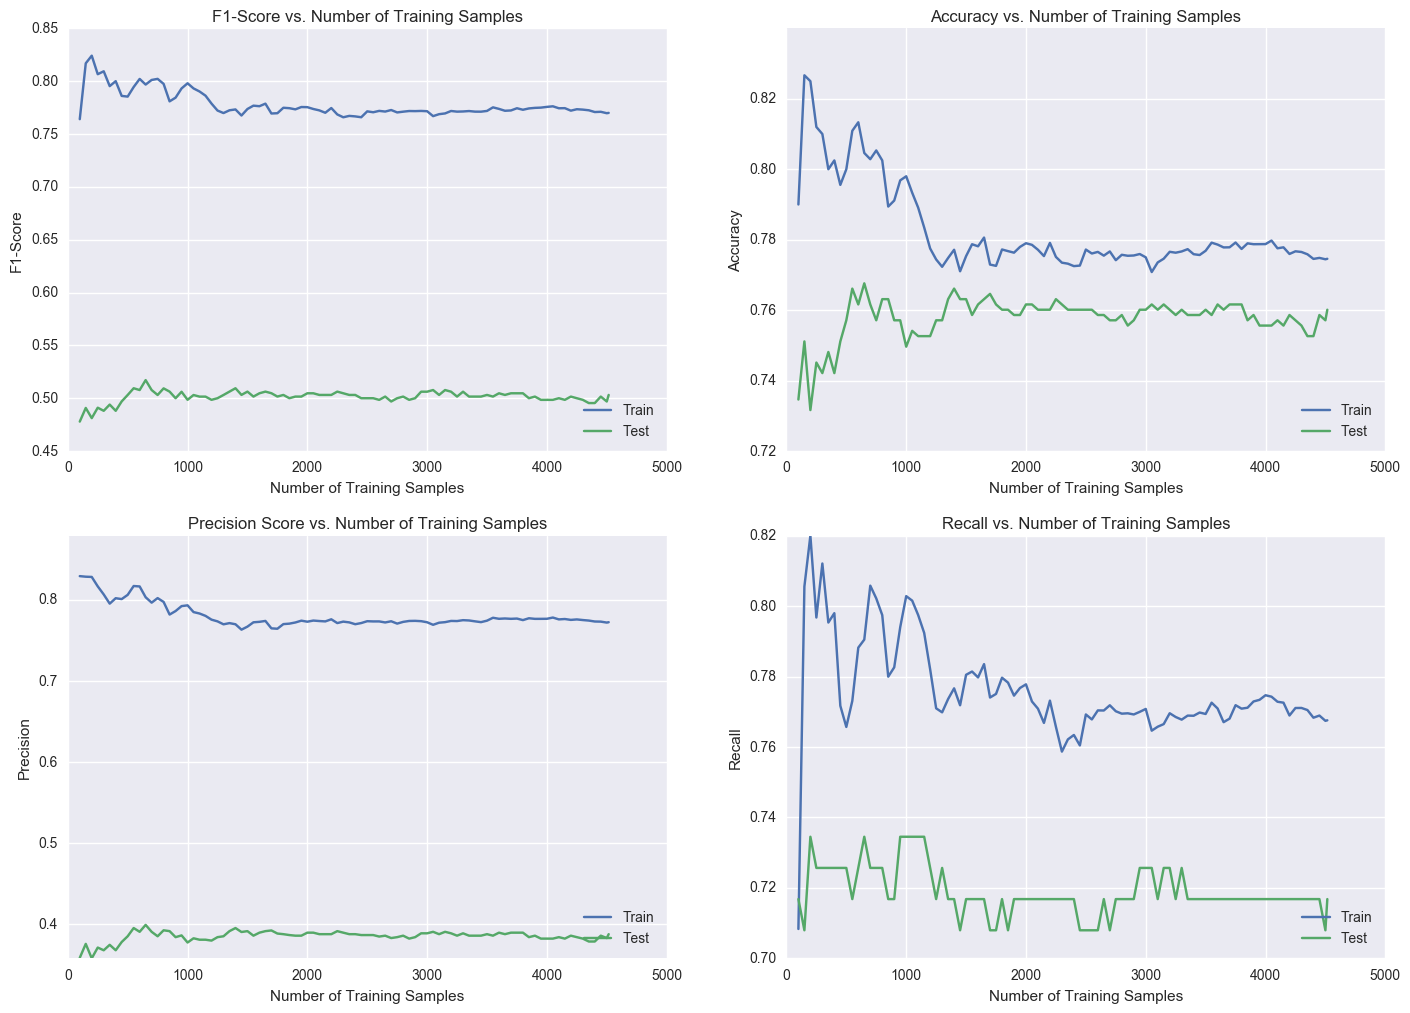

In [58]:
# best performing: oversampling, lasso, 3000 training points
X_train, X_holdout, Y_train, Y_holdout = train_test_split(X,Y, test_size = 0.20)
X_over, Y_over = oversample(X_train, Y_train, minority_weight=.5)

lr = LogisticRegression()

cv = cross_validation(lr, X_over, Y_over , n_splits=5, init_chunk_size = 100, chunk_spacings = 50, average = "binary")
# predict on original data
cv.validate_for_holdout_set(X_holdout,Y_holdout )
cv.plot_learning_curve()

In [ ]:
# change cell to markdown and write down your interpretation about what the learning curve 
# is telling us about Logistic REgression preformance in terms of the bias/variance tradeoff

### 1.6 Feature Engineering

The learning curves tell us that Logistic Regression is unable to learn any trends or hidden features form the data in order to classify users. Let's apply some feature engineering to help it out!

#### What if we take the mean and std of each row and assign those values to new features? 

The intuition here is that samples from the churn and non-churn populations have characteristic means and std that are unique to those populations. 

In [110]:
# print a head for reference
df2.head()

,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,VMail Plan,Churn
0,25,0.511403,0.333333,0.511402,0.085510,0.164706,0.085733,0.191501,-0.183099,0.191871,0.00,-0.7,0.000000,-0.777778,1,0
1,26,-0.078677,0.490909,-0.078806,0.075062,0.211765,0.075380,0.243679,-0.014085,0.244471,0.37,-0.7,0.370370,-0.777778,1,0
2,0,0.387685,0.381818,0.387659,-0.333517,0.294118,-0.333549,-0.250134,0.000000,-0.249253,0.22,-0.5,0.218519,-1.000000,0,0
3,0,0.706956,-0.139394,0.706908,-0.659610,0.035294,-0.659657,-0.065627,-0.211268,-0.065152,-0.34,-0.3,-0.340741,-0.555556,0,0
4,0,-0.049601,0.369697,-0.049631,-0.184493,0.435294,-0.184083,-0.119419,0.239437,-0.118948,0.01,-0.7,0.011111,-0.333333,0,0


In [147]:
# initialize the new features 
df2["row-means"] = np.ones((df2.shape[0], 1))
df2["row-std"] = np.ones((df2.shape[0], 1))

In [148]:
df2.head()

,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,VMail Plan,Churn,row-means,row-std
0,25,0.511403,0.333333,0.511402,0.085510,0.164706,0.085733,0.191501,-0.183099,0.191871,0.00,-0.7,0.000000,-0.777778,1,0,1.0,1.0
1,26,-0.078677,0.490909,-0.078806,0.075062,0.211765,0.075380,0.243679,-0.014085,0.244471,0.37,-0.7,0.370370,-0.777778,1,0,1.0,1.0
2,0,0.387685,0.381818,0.387659,-0.333517,0.294118,-0.333549,-0.250134,0.000000,-0.249253,0.22,-0.5,0.218519,-1.000000,0,0,1.0,1.0
3,0,0.706956,-0.139394,0.706908,-0.659610,0.035294,-0.659657,-0.065627,-0.211268,-0.065152,-0.34,-0.3,-0.340741,-0.555556,0,0,1.0,1.0
4,0,-0.049601,0.369697,-0.049631,-0.184493,0.435294,-0.184083,-0.119419,0.239437,-0.118948,0.01,-0.7,0.011111,-0.333333,0,0,1.0,1.0


In [234]:
agg_cols = df2.columns[1:-4]
agg_cols

Index([u'Day Mins', u'Day Calls', u'Day Charge', u'Eve Mins', u'Eve Calls',
       u'Eve Charge', u'Night Mins', u'Night Calls', u'Night Charge',
       u'Intl Mins', u'Intl Calls', u'Intl Charge', u'CustServ Calls'],
      dtype='object')

In [235]:
 df2[agg_cols].head()

,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls
0,0.511403,0.333333,0.511402,0.085510,0.164706,0.085733,0.191501,-0.183099,0.191871,0.00,-0.7,0.000000,-0.777778
1,-0.078677,0.490909,-0.078806,0.075062,0.211765,0.075380,0.243679,-0.014085,0.244471,0.37,-0.7,0.370370,-0.777778
2,0.387685,0.381818,0.387659,-0.333517,0.294118,-0.333549,-0.250134,0.000000,-0.249253,0.22,-0.5,0.218519,-1.000000
3,0.706956,-0.139394,0.706908,-0.659610,0.035294,-0.659657,-0.065627,-0.211268,-0.065152,-0.34,-0.3,-0.340741,-0.555556
4,-0.049601,0.369697,-0.049631,-0.184493,0.435294,-0.184083,-0.119419,0.239437,-0.118948,0.01,-0.7,0.011111,-0.333333


In [236]:
# population the new features with values 
df2["row-means"] = df2[agg_cols].T.apply(lambda row: np.mean(row))
df2["row-std"] = df2[agg_cols].T.apply(lambda row: np.std(row))

In [237]:
df2.head()

,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,VMail Plan,Churn,row-means,row-std
0,25,0.511403,0.333333,0.511402,0.085510,0.164706,0.085733,0.191501,-0.183099,0.191871,0.00,-0.7,0.000000,-0.777778,1,0,0.031891,0.378732
1,26,-0.078677,0.490909,-0.078806,0.075062,0.211765,0.075380,0.243679,-0.014085,0.244471,0.37,-0.7,0.370370,-0.777778,1,0,0.033253,0.370398
2,0,0.387685,0.381818,0.387659,-0.333517,0.294118,-0.333549,-0.250134,0.000000,-0.249253,0.22,-0.5,0.218519,-1.000000,0,0,-0.059743,0.409484
3,0,0.706956,-0.139394,0.706908,-0.659610,0.035294,-0.659657,-0.065627,-0.211268,-0.065152,-0.34,-0.3,-0.340741,-0.555556,0,0,-0.145219,0.420603
4,0,-0.049601,0.369697,-0.049631,-0.184493,0.435294,-0.184083,-0.119419,0.239437,-0.118948,0.01,-0.7,0.011111,-0.333333,0,0,-0.051844,0.284353


**Hypothesis Testing**
1. Choose a null ($H_0$) and alternative hypothesis ($H_1$)
2. Choose a significance level alpha, $\alpha$
3. Choose a statistical test
4. Calculate the test statistic 
5. Compare the p value with alpha

Our $H_0$ is that the difference between the distribution means is zero and our $H_1$ is the difference between the means is not zero

$$ H_0: \mu_0 - \mu_1 = 0 \\
H_1: \mu_0 - \mu_1 \neq 0
$$


 We'll choose $\alpha$ as 0.05 and we'll use the t-test as our statistical test. 

Finally we'll check the following conditions, 

$$ p < \alpha \rightarrow \text{reject}~ H_0 \\
p > \alpha \rightarrow \text{fail to reject}~ H_0 $$

In [238]:
# mask df in order to isolate the unique populatins 
# mask df in order to isolate the unique populatins 
churn_means = df2["row-means"][df2.Churn == 1]
non_churn_means = df2["row-means"][df2.Churn == 0]
churn_std = df2["row-std"][df2.Churn == 1]
non_churn_std = df2["row-std"][df2.Churn == 0]

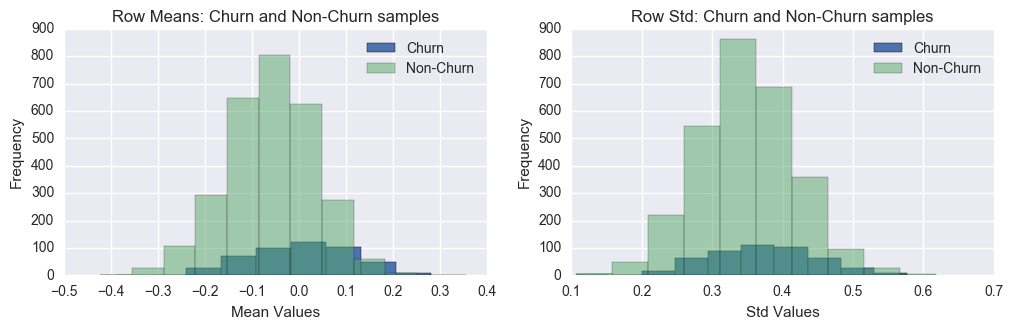

In [239]:
# plot your 4 Series
fig = plt.figure(figsize = (12,7))
fig.add_subplot(221)
plt.title("Row Means: Churn and Non-Churn samples")
plt.hist(churn_means, label = "Churn");
plt.hist(non_churn_means, alpha = 0.5, label = ("Non-Churn"));
plt.ylabel("Frequency")
plt.xlabel("Mean Values")
plt.legend();

fig.add_subplot(222)
plt.title("Row Std: Churn and Non-Churn samples")
plt.ylabel("Frequency")
plt.xlabel("Std Values")
plt.hist(churn_std, label = "Churn");
plt.hist(non_churn_std, alpha = 0.5,label = ("Non-Churn"));
plt.legend();

#### Perform a t test to check if the distributions are different

Check out the statsmodels doc for their t-test method [HERE](http://statsmodels.sourceforge.net/0.6.0/generated/statsmodels.stats.weightstats.ttest_ind.html)

In [240]:
# run a ttest for the churn mean distributions 
t_stat, p_value, dof = ttest_ind(churn_means, non_churn_means)
p_value

3.793156095412465e-41

In [241]:
# run a ttest for the std mean distributions 
t_stat, p_value, dof = ttest_ind(churn_std, non_churn_std)
p_value

4.3383399342181374e-10

### Hypothesis Testing Results

The results from the hypothesis tests show that the row means and std of each churn and non-churn sample are in fact samples from unique populations. This means that the two new features that we engineered show a statistically significant difference in their distribution means. We can be assured that the two new features that we engineered will introduce more descriptive signal about the two classes, and not more error (noise).

In [242]:
# print out a head 
df2.head()

,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,VMail Plan,Churn,row-means,row-std
0,25,0.511403,0.333333,0.511402,0.085510,0.164706,0.085733,0.191501,-0.183099,0.191871,0.00,-0.7,0.000000,-0.777778,1,0,0.031891,0.378732
1,26,-0.078677,0.490909,-0.078806,0.075062,0.211765,0.075380,0.243679,-0.014085,0.244471,0.37,-0.7,0.370370,-0.777778,1,0,0.033253,0.370398
2,0,0.387685,0.381818,0.387659,-0.333517,0.294118,-0.333549,-0.250134,0.000000,-0.249253,0.22,-0.5,0.218519,-1.000000,0,0,-0.059743,0.409484
3,0,0.706956,-0.139394,0.706908,-0.659610,0.035294,-0.659657,-0.065627,-0.211268,-0.065152,-0.34,-0.3,-0.340741,-0.555556,0,0,-0.145219,0.420603
4,0,-0.049601,0.369697,-0.049631,-0.184493,0.435294,-0.184083,-0.119419,0.239437,-0.118948,0.01,-0.7,0.011111,-0.333333,0,0,-0.051844,0.284353


In [243]:
# create X_cols which contain all but the churn column
X_cols = df2.columns[:-3].union(df2.columns[-2:])
# create X2 design matrix to include our new features
X2 = df2[X_cols].values
# create Y2 desgin matrix for consistancy
Y2 = df2.Churn.values

In [244]:
X2.shape, Y2.shape

((3333, 17), (3333,))

In [245]:
# run a train test split on X2 and Y2
X_train, X_test, X_holdout, Y_holdout = train_test_split(X2, Y2, test_size = 0.2)

In [246]:
X_train.shape, X_test.shape, X_holdout.shape, Y_holdout.shape

((2666, 17), (667, 17), (2666,), (667,))

### 1.7 Cross-Validate Model with New Data

Now that we've feature engineered two statistically sound features, let's see how Logistical Regression responds. 

### Undersampling

In [247]:
X_under, Y_under = undersample(X_train, Y_train, majority_weight=.5)

/Users/Alexander/anaconda3/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [248]:
X_under.shape, Y_under.shape

((766, 17), (766,))

In [249]:
lr = LogisticRegression(penalty='l2')
cv = cross_validation(lr, X_under, Y_under , n_splits=5,init_chunk_size = 100, chunk_spacings = 50, average = "binary")
cv.validate_for_holdout_set(X_holdout, Y_holdout)
cv.plot_learning_curve()

/Users/Alexander/anaconda3/envs/dsi/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


ValueError: X has 2666 features per sample; expecting 17

In [250]:
# change cell to markdown and write down your interpretation about what the learning curve 
# is telling us about Logistic REgression preformance in terms of the bias/variance tradeoff

### Oversampling

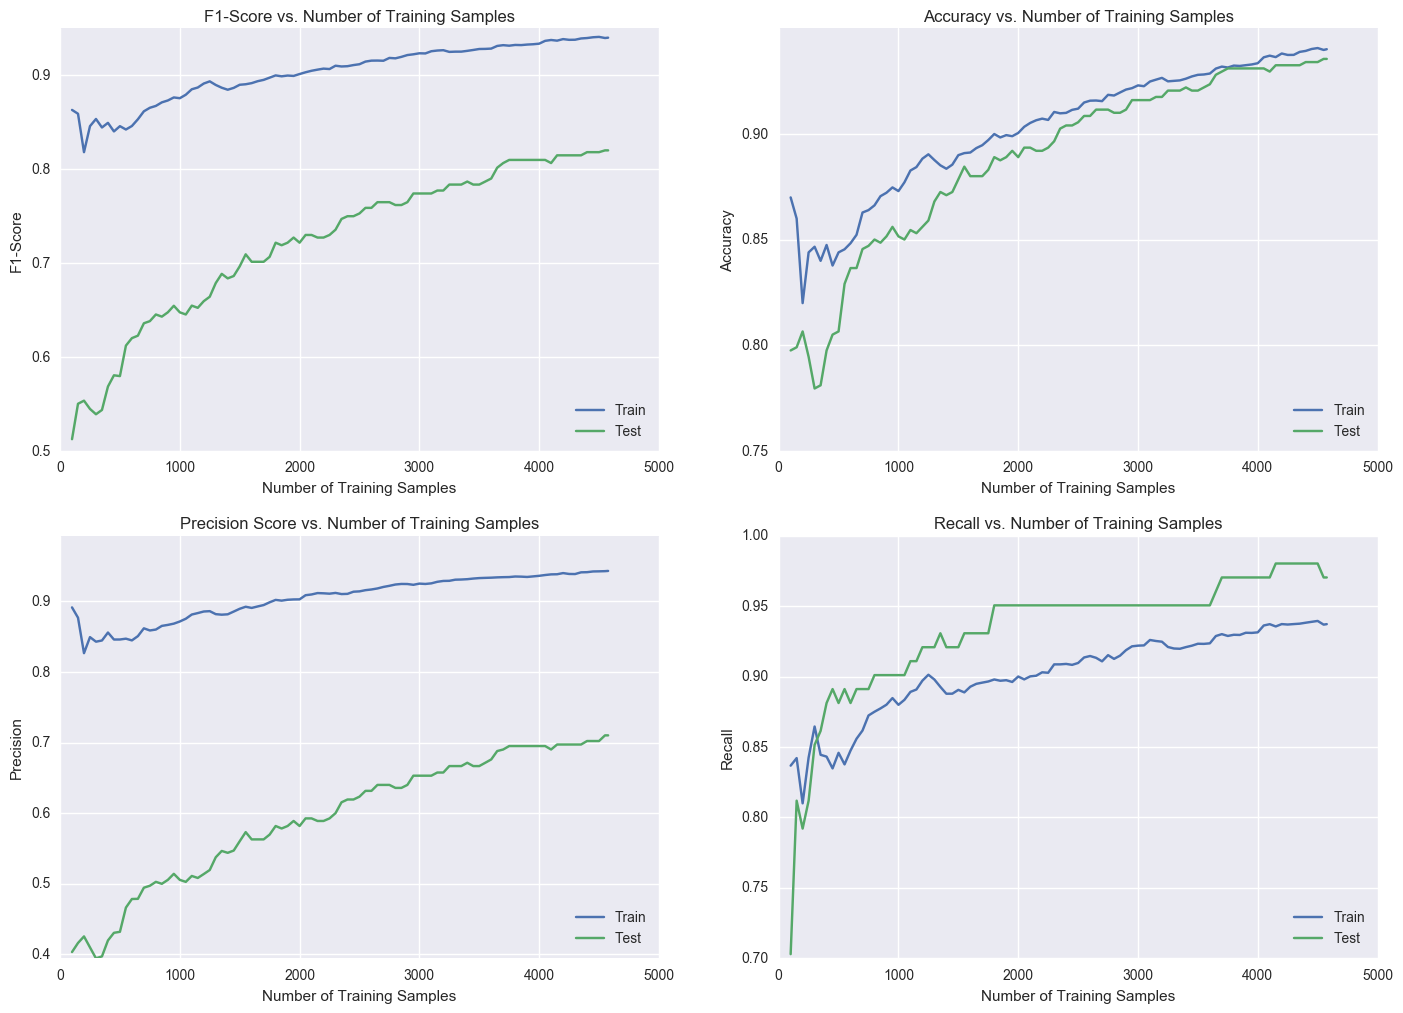

In [128]:
X_over, Y_over = oversample(X_train, Y_train, minority_weight=.5)
lr = LogisticRegression(penalty='l2')
cv = cross_validation(lr, X_over, Y_over , n_splits=5,init_chunk_size = 100, chunk_spacings = 50, average = "binary")
cv.validate_for_holdout_set(X_holdout, Y_holdout)
cv.plot_learning_curve()

In [ ]:
# change cell to markdown and write down your interpretation about what the learning curve 
# is telling us about Logistic REgression preformance in terms of the bias/variance tradeoff

### Smote

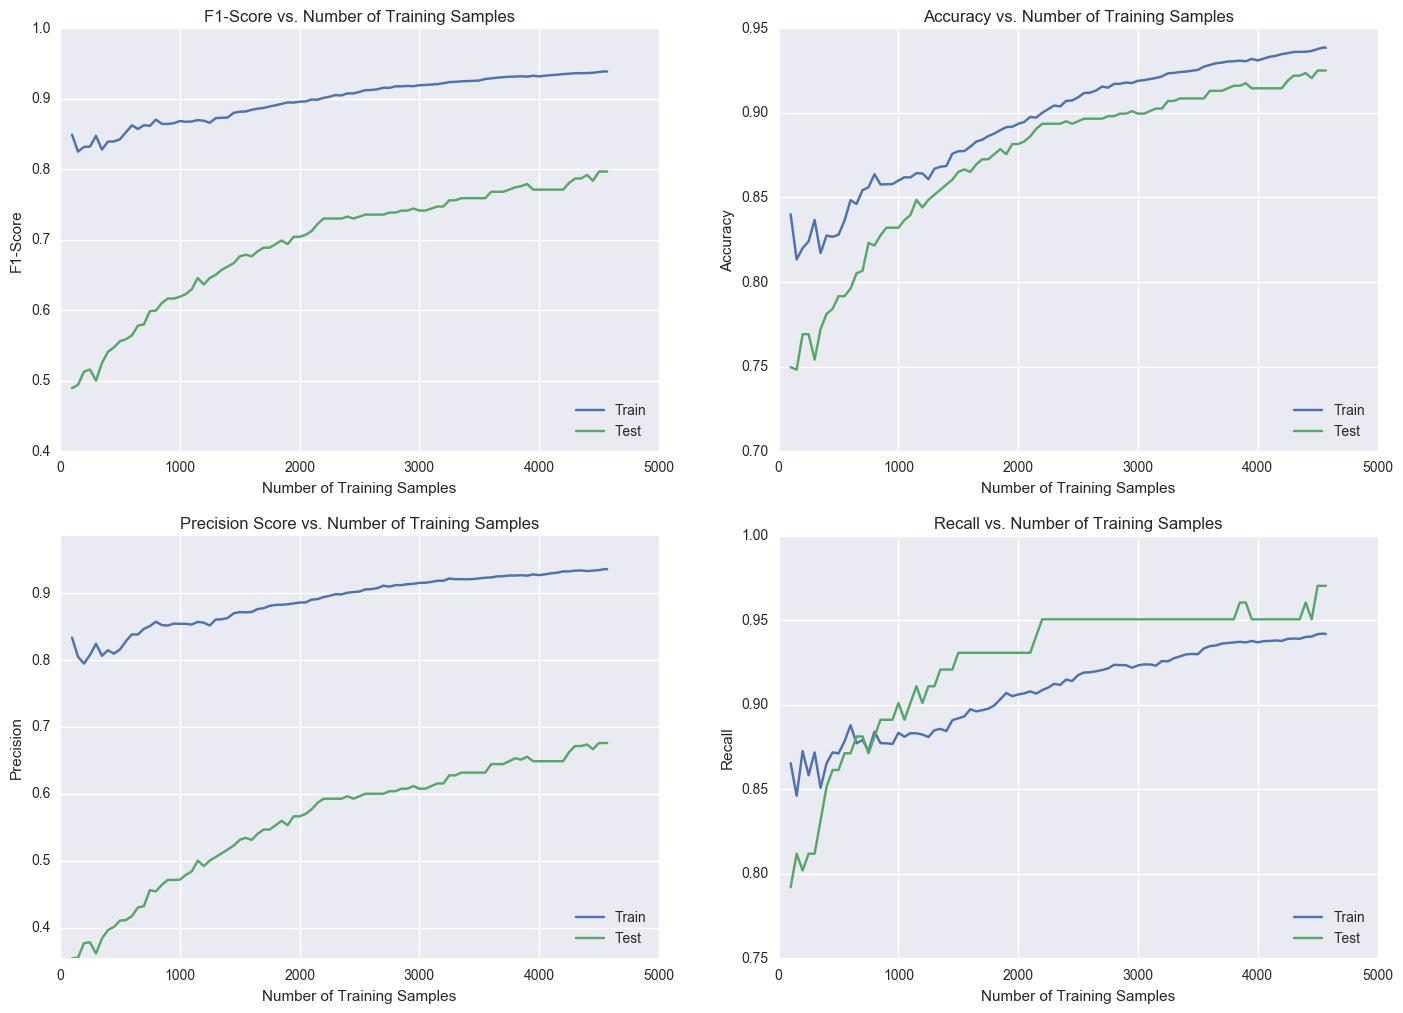

In [129]:
sm = SMOTE(kind='regular')
X_smote, Y_smote= sm.fit_sample(X_train, Y_train)

# let's see how well LR can fit and predict on the smote data
lr = LogisticRegression(penalty='l2')
cv = cross_validation(lr, X_smote, Y_smote , n_splits=5, init_chunk_size = 100, chunk_spacings = 50, average = "binary")
cv.validate_for_holdout_set(X_holdout, Y_holdout)
cv.plot_learning_curve()

In [ ]:
# change cell to markdown and write down your interpretation about what the learning curve 
# is telling us about Logistic REgression preformance in terms of the bias/variance tradeoff

### Use Over Sampling

It appears that oversampling the minority class leads to slight, but noticably better performance for our model. For this reason, we will move forward with our analsis using the oversampling data.

In [310]:
X_over, Y_over = oversample(X_train, Y_train, minority_weight=.5)

# let's see how well LR can fit and predict on the smote data
lr = LogisticRegression(penalty='l2')
lr.fit(X_over, Y_over )
y_hat = lr.predict(X_holdout)
y_prob = lr.predict_proba(X_holdout)

print accuracy_score(Y_holdout, y_hat), precision_score(Y_holdout, y_hat), recall_score(Y_holdout, y_hat)

print confusion_matrix(Y_holdout, y_hat)

0.706146926537 0.265765765766 0.641304347826
[[412 163]
 [ 33  59]]


### Roc Curve

In [311]:
fpr, tpr, thresholds = roc_curve(Y_holdout, y_prob.T[1])
area_under_curve = auc(fpr, tpr)
x = np.arange(0,Y_holdout.shape[0]+1, Y_holdout.shape[0])
y = x

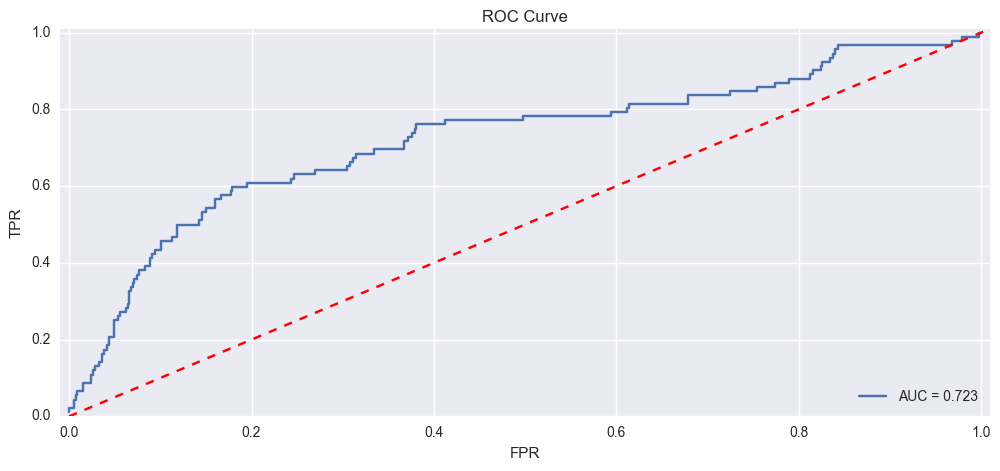

In [312]:
plt.figure(figsize = (12,5))
plt.title("ROC Curve")
plt.ylabel("TPR")
plt.xlabel("FPR")
plt.xlim(-0.01, 1.01)
plt.ylim(0,1.01)
plt.plot(fpr, tpr, label = "AUC = {:.3}".format(area_under_curve));
plt.plot(x,y,'--r');
plt.legend(loc='lower right');

The ROC Curve let's us "fine tune" our model's predictive performance by "turning the nobs" on the values of TPR and FPR. Let's play around with the TPR and the FPR to see how the precision and recall is affected.

In [798]:
def scan_roc_scores(tp_default, fp_default, tpr, fpr, thresholds):
    '''Iterate through the tpr, fpr, and threshold values of a roc curve
       and compare them to the default tp and fp of the classifer. 
       
       Return tp_rate_, fp_rate, thresholds, index if scores are better
       default.'''
    index = 0
    for  tp_rate_, fp_rate, thresh in zip(tpr, fpr, thresholds):
        if tp_rate_ >= tp_default and fp_rate <= fp_default:
            return tp_rate, fp_rate, thresh, index
        index += 1
    return "Default Results are better"

In [655]:
tp_default = 0.90
fp_default = 0.10

tp_rate, fp_rate, thresh, index = scan_roc_scores(tp_default, fp_default, tpr, fpr, thresholds)
tp_rate, fp_rate, thresh, index

(0.76767676767676762, 0.023297491039426525, 0.6597825147246339, 19)

In [656]:
# make new predictions based on threshold for predicted probabilities 
new_pred = [1  if prob >= thresh else 0 for prob in y_prob.T[1] ]

print accuracy_score(Y_holdout, new_pred), precision_score(Y_holdout, new_pred), recall_score(Y_holdout, new_pred)

confusion_matrix(Y_holdout, new_pred)

0.967016491754 0.884955752212 0.917431192661


array([[545,  13],
       [  9, 100]])

In [706]:
new_pred = [1  if prob >= 0.50 else 0 for prob in y_prob.T[1] ]

# how much decrease in recall are we willing to tolarate in favor of higher precison?
print accuracy_score(Y_holdout, new_pred), precision_score(Y_holdout, new_pred), recall_score(Y_holdout, new_pred)

confusion_matrix(Y_holdout, new_pred)

0.941529235382 0.761194029851 0.935779816514


array([[526,  32],
       [  7, 102]])

### 1. 8 Precision Recall Curve

### Question: 

If we wanted to use our model to send coupons to users that were at risk of churning, what stratgy would lead to greater profit?

1. 90% Precision and 10% Recall?

2. 10% Precision and 90% Recall?

3. Or somewhere in between?

Check out the doc on the Precision Recall Curve [HERE](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html#sklearn.metrics.precision_recall_curve)

In [658]:
precision, recall, pre_rec_thresholds = precision_recall_curve(Y_holdout, y_prob.T[1])
area_under_precision_recall_curve = average_precision_score(Y_holdout, y_hat)

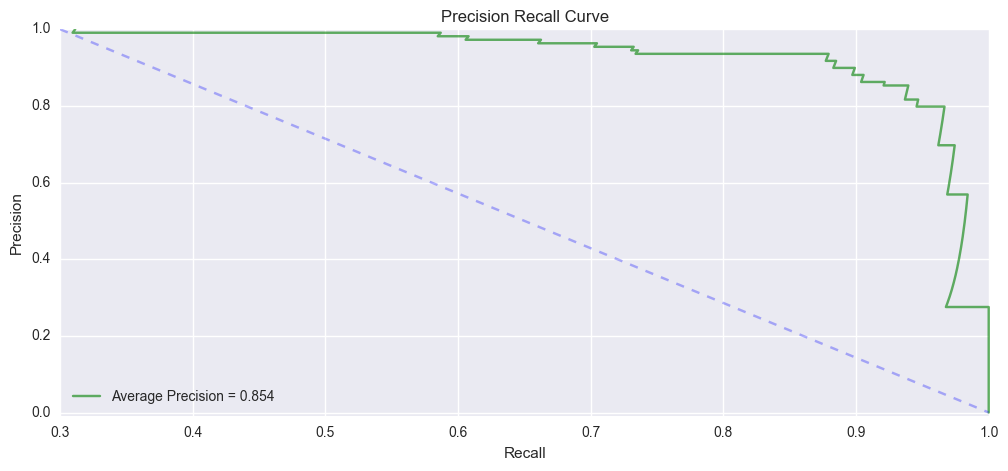

In [659]:
plt.figure(figsize = (12,5))
plt.title("Precision Recall Curve")
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.plot(precision, recall, 'g', alpha = 0.6, 
         label = "Average Precision = {:.3}".format(area_under_precision_recall_curve));

x = np.linspace(0.3, 1.0, len(precision))
y = np.linspace(1.0, 0, len(precision))
plt.plot(x, y, '--b', alpha = 0.3)
plt.xlim((0.3, 1.001))
plt.ylim((-0.01, 1.001))
plt.legend(loc='lower left');

>A system with high recall but low precision returns many results, but most of its predicted labels are incorrect when compared to the training labels. A system with high precision but low recall is just the opposite, returning very few results, but most of its predicted labels are correct when compared to the training labels. An ideal system with high precision and high recall will return many results, with all results labeled correctly. [Sklearn Docs](http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#sphx-glr-auto-examples-model-selection-plot-precision-recall-py)

### 1.9 Logistic Regression: Interpretation of Feature Weights

We define the odds of Y = 1 as,
$$odds = \frac{P(Y = 1)}{1 - P(Y = 1)} = e^{\beta_0 + \beta_1 X_1 + \cdots + \beta_p X_p}$$

We interpret the $\beta's$ in multiplicative terms with respect to the odds.

E.g., the interpretation of $\beta_1$ is, holding all the other variables/features fixed, for every increase of 1 in $X_1$, the odds of $Y = 1$ increases by a factor of $e^{\beta_1}$.

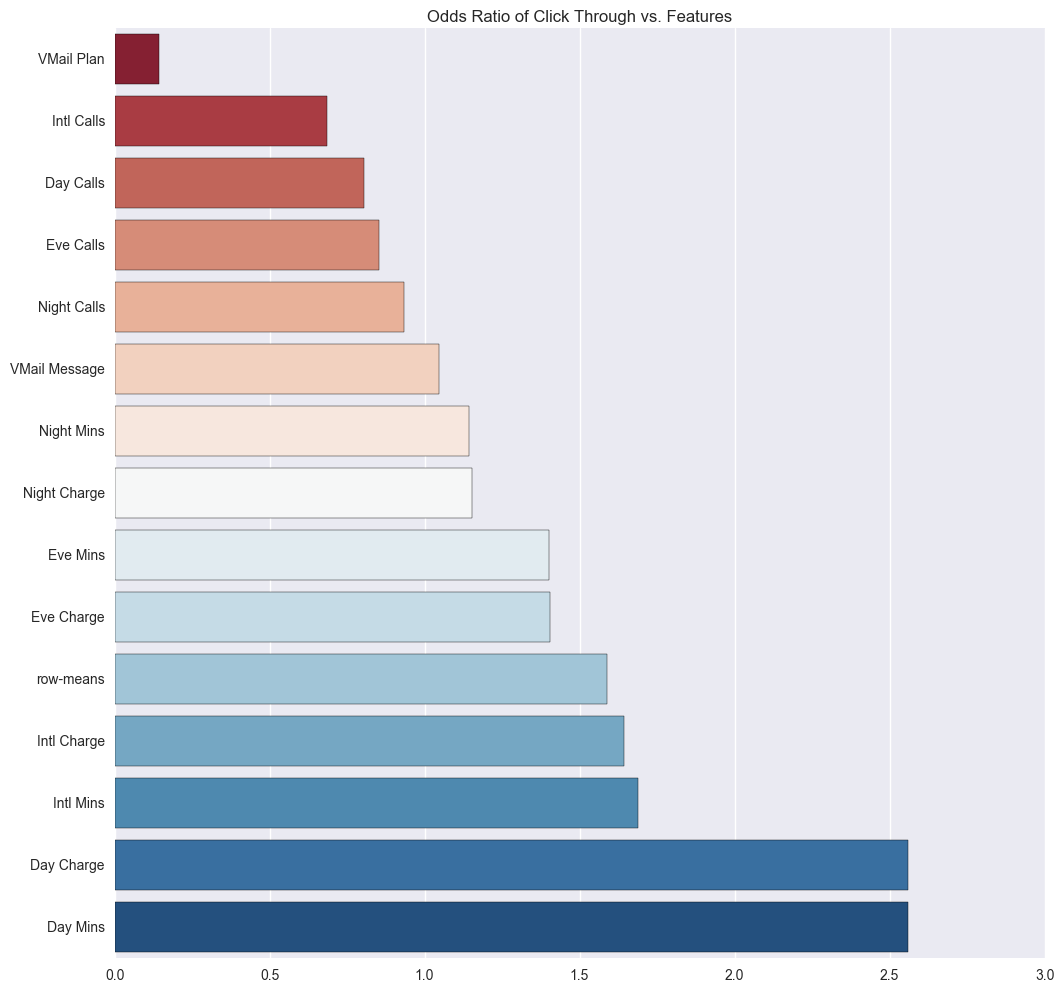

In [314]:
# cut off training to prevent overfitting 
lr = LogisticRegression(penalty='l2');
lr.fit(X_over, Y_over);
# remove nested list
feature_weights = np.exp(lr.coef_[0])
# sort features by odds
sorted_features = feature_weights[np.argsort(feature_weights)]

plt.figure(figsize = (12,12))
plt.title('Odds Ratio of Click Through vs. Features')
sb.barplot(sorted_features[:-2], X2_cols[np.argsort(feature_weights)][:-2], palette="RdBu");

## 1. 10 Actionable Insight and Profit Cruves

In order to apply our findings of the predictive probabilities and ROC Curve, we will create a profit curve. The first step to creating a profit curve is to construct a **cost benefit matrix.**

                    Features that are most predictive of Churn

                                    CustServCalls
                                    VMail Messages
                                    Int'l Plan
                                    Day Mins
                                    
Let's say that we want to incentivize users that are predicted of churning to stay with a 10 dollar coupon good towards the purchase of 100 dollars worth of International Call minutes and/or Day time minutes. Ignoring Vail Messages, International Calls (Intl Calls) and Day time minutes (Day Mins) were ranked as the most important features (behind CustServCalls)that predict churn by the Logistic Regression classifier. Also let's say their is a 5 dollar cost to mailing the coupon. 


Case 1: If users are predicted to stay, do not mail coupon.

Case2:  If users are predicted to leave, then mail coupon and consider 2 sub-cases.

    Sub-case1: User buys, then the business makes a $85 profit and retains a user.

    Sub-case2: user doesn't buy, then the business loses $5 and a user. 
    
                      
                                     will buy  won't buy
                             leave   | $85    | -$5   |
                             stay    | $0     |  $0   |
                         
Rewriting this in a confusion matrix:

                                         Actual
                                     No churn  churn
            Prediction   No churn    |  TN = $0    |  FN = $0  |
                            churn    |  FP = $-15  |  TP = $85 |                        
                         
                         
                        confusion matrix has sklearn orientation:
                                     | TN | FP |
                                     | FN | TP |
                                     
>Sklearn: Binary classification, the count of true negatives is C_{0,0}, false negatives is C_{1,0}, true positives is C_{1,1} and false positives is C_{0,1}.                                     

### Establish a baseline

We first want to establish a baseline. A basic appraoch is to mail a coupon to every single user that is predicted postive for churn. All False Positives will cost us money and all True Positives will make use money. 

In [320]:
lr = LogisticRegression(penalty='l2')
lr.fit(X_over, Y_over )
y_hat = lr.predict(X_holdout)
y_prob = lr.predict_proba(X_holdout)

In [321]:
# total number of costumers in our sample population 
X_holdout.shape[0]

667

In [322]:
cm = confusion_matrix(Y_holdout, y_hat)
cm

array([[412, 163],
       [ 33,  59]])

In [323]:
FP = cm[0][1]
TP = cm[1][1]
print FP, TP

163 59


In [324]:
cost_from_FP = FP * -15
cost_from_FP

-2445

In [325]:
profit_from_TP = TP * 85
profit_from_TP

5015

In [326]:
# expected profit by sending coupons to all costomers that are predicted to churn 
profit_baseline = profit_from_TP + cost_from_FP
profit_baseline

2570

In [327]:
#             | TN | FP |
#             | FN | TP |


# cost benefit of mailing $10 coupon (good towards a $100 purchase) at a cost of $5 mailing fee
cb = np.array([[0,-15],
               [0,85]])
cb

array([[  0, -15],
       [  0,  85]])

#### Code to calculate a profit curve

In [328]:
def confusion_rates(cm):
    '''
    INPUT:  confusion_matrix 2-by-2 array must have sklearn orientation:
            | TN | FP |
            | FN | TP |
    OUTPUT: confusion_rates 2-by-2 array will have orientation:
            |TPR | FPR|
            |FNR | TNR|
    '''
    # TPR = TP / ( TP + FN )
    TPR = cm[1][1] / ( cm[1][1] + cm[1][0] )
    # FPR = FP / ( FP + TN ) 
    FPR = cm[0][1] / ( cm[0][1] + cm[0][0])
    # FNR = FN /  (FN + TP)
    FNR = cm[1][0] / ( cm[1][0] + cm[1][1])
    # TNR = TN / (TN + FP) 
    TNR = cm[0][0] / ( cm[0][0] + cm[0][1])
    
    return np.array([[TPR, FPR],[FNR, TNR]])

In [329]:
def profit(cb, cr, p_true, p_false):
    '''
    INPUT:  confusion_matrix 2-by-2 array must have sklearn orientation:
            | TN | FP |
            | FN | TP |
            confusion_rates 2-by-2 array will have orientation:
            |TPR | FPR|
            |FNR | TNR|
            p_true: prior probability of true classification (float)
            p_false: prior probability of false classification (float)
    OUTPUT: Profit values 1-dim array
    '''
    # cost/benefit values
    TP = cb[1][1]
    FP = cb[0][1]
    FN = cb[1][0]
    TN = cb[0][0]
    # rates
    TPR = cr[0][0]
    FPR = cr[0][1]
    FNR = cr[1][0]
    TNR = cr[1][1]

    return  p_true * ( TP*TPR + FN*FNR ) + p_false * ( FP*FPR + TN*TNR )  

In [330]:
def get_sorted_probs(model,Xtrain,Xtest,ytrain,ytest):
    
    # Build the model on the training set
    model.fit(Xtrain,ytrain)
    # Get the predict probabilities for the test set
    pred_prob = model.predict_proba(Xtest)
    # seperate prob true and prob false
    P_false_churn = pred_prob.T[0] # no churn
    P_true_churn  = pred_prob.T[1] # yes churn
    # Sort probs indices
    false_sort = np.argsort(P_false_churn)
    true_sort = np.argsort(P_true_churn)
    # Sort probs for looping through threshold
    P_false_churn_sort = P_false_churn[false_sort]
    P_true_churn_sort = P_true_churn[true_sort]
    return P_false_churn_sort, P_true_churn_sort        

In [331]:
def predict_churn_alphas(P_false_sorted):
    # loop through threshold values
    # predict churn/no churn based on if prob is above or below threshold
    pred_churn_alphas = []
    alphas = []
    for alpha in P_false_sorted: # no churn
        pred_churn_alpha = []
        alphas.append(alpha)
        for prob in P_false_sorted:
            if prob >= alpha:
                pred_churn_alpha.append(1) # yes churn
            else:
                pred_churn_alpha.append(0) # no churn
        pred_churn_alphas.append(pred_churn_alpha) # list of predictions for each alpha
    return pred_churn_alphas, alphas

In [332]:
def profit_curve(Xtrain, Xtest, ytrain, ytest,CB, *models):
    for model in models:
        
        P_false_sorted, P_true_sorted = get_sorted_probs(model,Xtrain,Xtest,ytrain,ytest)
    
        pred_churn_alphas, alpha_lst = predict_churn_alphas(P_false_sorted)
        # calculate confusion matrix for every alpha
        profit_values = []
        percent_pos_pop = []
        
        for y_pred, p_true,p_false in zip(pred_churn_alphas, P_true_sorted,P_false_sorted):
            
            # calcualte confusion matrix for every alpha
            cm = confusion_matrix(ytest, y_pred)
            
            # calculate confusion rates for every alpha
            cr = confusion_rates(cm)

            # calculate percent of Positive Prediction population
            percent_pos_pop.append((cm[0][0] + cm[1][1])\
                                   / (cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1])  * 100)

   
            # calculate profit for every alpha
            profit_values.append(profit(CB, cr, p_true,p_false))
        
    return percent_pos_pop, profit_values
    

In [333]:
percent_pos_pop, profit_values = profit_curve(X_over,X_holdout,Y_over, Y_holdout, cb, lr)

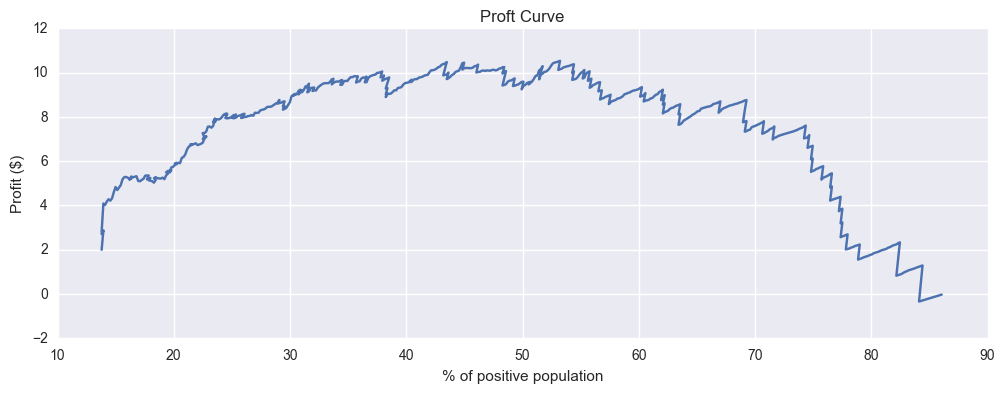

In [334]:
# plot profit curve
plt.figure(figsize = (12,4))
plt.plot(percent_pos_pop, profit_values)
plt.title("Proft Curve")
plt.xlabel("% of positive population")
plt.ylabel("Profit ($)")
plt.show()

The plot tells us that the maximum cumulative profit is made by targeting the top-ranked 70% of consumers. 



>We can produce a list of instances and their predicted scores, ranked by decreasing score, and then measure the expected profit that
would result from choosing each successive cut-point in the list. Conceptually, this
amounts to ranking the list of instances by score from highest to lowest and sweeping
down through it, recording the expected profit after each instance. At each cut-point
we record the percentage of the list predicted as positive and the corresponding esti
mated profit. Graphing these values gives us a profit curve. 

>-- Data Science for Business




Every single time we vary the probability threshold for predicitng a person as a churn or non-churn, we calculate an expected profit from the populaiton: 


$$ \text{profit} = P_{true} * ( TP*TPR + FN*FNR ) + P_{false} * ( FP*FPR + TN*TNR ) $$

This expected value means that if we apply this model to a population of 
customers predicted to churn and mail offers to those it classifies as positive, we can expect to make an
average of about $X$ dollars per person, $X$ being the result of the above exquation. 

----

The **predict_churn_alphas** function iterates through every possible prediction threshold. Meaning it scans through the predicted probabilities from about 1 to 99 and uses them as thresholds $\alpha$ and classifies a user as a churn or non-churn depending if their predicted probability is above or below $\alpha$. 

---

In [335]:
cumulative_profit = []
for population, profit_ in zip(percent_pos_pop, profit_values):
    if population <= 80:
        cumulative_profit.append(profit_)
        
cumulative_profit = np.sum(cumulative_profit)

### Results

In [336]:
# expcted profit from sending coupons to all users that are predicted of churning
print profit_baseline

# expected profit from sending coupons to the 80 percent of the postive class with the highest probability of churn
print cumulative_profit

# total possible profit that can be made with a classifer that predicts classes perfectly, 
# given the current X_holdout set
print FP  * 85 + TP * 85

2570
4979.67406438
18870


## Can we do better?

Recall that our Logistic Regression only had a precison score of around 70%. If we had a model with a precision scoure around 90% or 98% --  we could expect much higher profits.

We need a model that can better distinguish points between the churn and non-churn distribtuions. 

# Resources

Read all about **Profit Curves** here: [Data Science for Business](http://iiseb.knu.ac.kr/Lecture/2016/B.pdf). This text will explain the theory behind profit curves, how they are calculated, and how to interpret them. The text will also explains a lot of other data science tools: **ROC Curves**, **Unbalnced Classes**, ...

Precision Recall Case Study with Imbalanced Data Set [Case Study One](https://classeval.wordpress.com/simulation-analysis/roc-and-precision-recall-with-imbalanced-datasets/) This article investigates the effects of an imbalanced data set on recall and precision. **TAKE AWAY:** ROC Curve analysis is limited and suffers with imbalanced data sets, where as Recall Precision Curves takes imbalanced labels into account. 

Precision Recall Case Study with Imbalanced Data Set [Case Study Two](https://classeval.wordpress.com/reanalysis-of-a-previous-study/) This case study revisits the analysis made in the Case Study One but with a different data set. 